In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
markersize = 10

# function for calculating standard deviation of probability distribution
def weighted_std(values, weight_prior):
    mask_average = np.ma.average(values, axis=1, weights=weight_prior)
    ma_mat = np.tile(mask_average, (len(values[0]), 1)).T
    variance = np.ma.average((values-ma_mat)**2, axis = 1, weights=weight_prior)
    variance = variance.filled(np.nan)
    return( np.sqrt(variance) )


plt.rcParams.update({'font.size': 13})

## A Bayesian account of the Phantom Lighthouse illusion

The prior could be created by sampling thousands of scenes, but here we use another approach -- for each angle, we enumerate all of the distances consistent with our generative assumptions, and store the actual prior probability of each one (up to a normalizing constant). Sampling is conceptually simpler and therefore a useful way to check our inferences. But enumerating the prior as done here is likely to lead to cleaner results because it handles low probability observations more gracefully.

We consider a setting in which there are NBOX identical boxes uniformly distributed over the range [DMIN, DMAX]. All boxes are sitting on the ground. Occlusion means that the depth of the closest box $m$ is distributed proportional to $(\text{DMAX}-m)^{\text{NBOX}-1}$.

The code here assumes that the observer's eye and the ground plane both have $y = 0$ (i.e. the observer is of zero height). In the paper we keep the observers eye at $y = 0$ but say that the ground plane is at $y = -2$ (i.e. the observer is 2 metres tall). The prior here, however, is equivalent to the prior we'd get for the setting in the paper (ground plane at $y = -2$) if we added 2m to each box (ie if the box heights were drawn from (3,27) rather than (1,25).

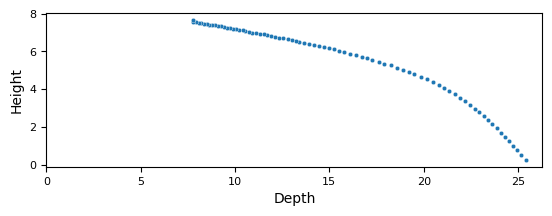

In [23]:
nbox = 5                                # number of boxes
angles = np.arange(0.01, np.pi/4, 0.01) # only up to np.pi/4 because that's roughly what Yang + Purves show in Fig 5c
hmin, hmax = (1,25)                     # box heights (using scale where 0 = the height of the observer)
dmin, dmax = (1,150)                    # box depths

heights = np.arange(hmin,hmax)
depths = np.arange(dmin,dmax)

# Occlusion means that smaller depths are more likely, and we allow for occlusion by taking a weighted average
# with the following weights 
depth_weights = np.power(dmax-depths, nbox - 1) 
weight_mat = np.tile(depth_weights, (len(angles), len(heights), 1) )
angle_array = np.tile(angles, (len(heights) * len(depths), 1)).T

angle_height_depth = np.zeros((len(angles), len(heights), len(depths)))
for ai in np.arange(len(angles)): # consider all angle, box height pairs
    angle = angles[ai]
    for hj in np.arange(len(heights)):
        height = heights[hj]
        adh  = depths * np.tan(angle) # heights corresponding to ANGLE and the depths in DEPTHS
        angle_height_depth[ai,hj,:] = depths 
        angle_height_depth[ai,hj,adh > height] = np.nan # all depths with a height at ANGLE that exceeds the actual box
                                                        # height set to NAN 

depth_prior = angle_height_depth.reshape((len(angles), -1))
weight_prior = weight_mat.reshape((len(angles), -1))
# convert to masked array to allow for weighted average
# depth_prior_masked is a 2D array with angles as rows and depths as columns
depth_prior_masked = np.ma.masked_array(depth_prior, np.isnan(depth_prior))
# distance_prior_masked is a 2D array with angles as rows and distances as columns
distance_prior_masked = depth_prior_masked / np.cos(angle_array) 

mask_average = np.ma.average(depth_prior_masked, axis=1, weights=weight_prior)
angle_depth = mask_average.filled(np.nan)

df = pd.DataFrame(angles, columns=['Angle'])
df['Depth'] = angle_depth
df['Distance'] =  df['Depth']/np.cos(df['Angle'])
df['Height'] =  df['Depth']*np.tan(df['Angle'])
# compute uncertainty about radial distances
df['StDev'] = weighted_std(distance_prior_masked, weight_prior)
df['LowerDepth'] = (df['Distance'] - df['StDev']) * np.cos(df['Angle'])
df['UpperDepth'] = (df['Distance'] + df['StDev']) * np.cos(df['Angle'])
df['LowerHeight'] = (df['Distance'] - df['StDev']) * np.sin(df['Angle'])
df['UpperHeight'] = (df['Distance'] + df['StDev']) * np.sin(df['Angle'])

fig_data = df[['Angle', 'Depth', 'Height', 'LowerDepth', 'UpperDepth', 'LowerHeight', 'UpperHeight']]
fig_data.to_csv('prior_data_journal.csv', index=False)

plt.axes().set_aspect('equal')
sns.scatterplot(data=df, x="Depth", y="Height", s=markersize)
plt.xlim(xmin=0)
plt.show()

### Bent Beam Illusion
Now use the prior for inference. First calculate perceived depths for an observer looking along a single static beam.

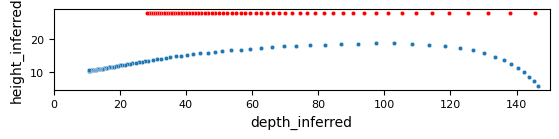

In [24]:
observer_height = 2
beam_height = 30 - observer_height
sigma = 20
dd_scaling = 0  # 0 means constant sigma, 1 means sigma proportional to distance
likelihood_multiplier = 0 # 0 makes the likelihood uniform, 1 leaves it specified by dd_scaling

# compute posterior mean for data points with true distances given by DISTANCE_TRUE
# rows of ANGLE_DISTANCE specify distances for the angle corresponding to each data point
# each row of ANGLE_DISTANCE_PRIOR specifies an angle-dependent prior over these distances

def posterior_mean(distance_true, angle_distance, angle_distance_prior, dd_scaling, likelihood_multiplier):
    n = angle_distance_prior.shape[1]
    distance_true_mat = np.tile(distance_true, (n, 1)).T
    sigmas_dd = np.tile(sigma * distance_true ** dd_scaling, (n, 1)).T
    likelihood = np.exp(likelihood_multiplier * (-0.5/(sigmas_dd **2))  * (angle_distance - distance_true_mat)**2 )
    posterior = angle_distance_prior * likelihood
    row_sums = posterior.sum(axis=1)
    posterior = posterior / row_sums[:, np.newaxis]
    return(np.ma.average(angle_distance, axis=1, weights=posterior))

def prior_and_inference(beam_height,  dd_scaling, likelihood_multiplier):
    # depth_prior_masked is a 2D array with angles as rows and depths as columns
    angle_array = np.tile(angles, (len(heights) * len(depths), 1)).T
    distance_prior_masked = depth_prior_masked / np.cos(angle_array) # distance_prior_masked is a 2D array with angles as rows and distances as columns

    # row-wise prior over the distances in distance_prior
    row_sums = weight_prior.sum(axis=1)
    prior = weight_prior / row_sums[:, np.newaxis]

    df = pd.DataFrame(angles, columns=['angle'])
    df['distance_true'] = beam_height / np.sin(df['angle'])
    df['height_true'] = beam_height
    df['depth_true'] = df['distance_true'] * np.cos(df['angle'])
    df['distance_inferred'] = posterior_mean(df['distance_true'], distance_prior_masked, prior, dd_scaling, likelihood_multiplier)
    df['height_inferred'] = df['distance_inferred'] * np.sin(df['angle'])
    df['depth_inferred'] = df['distance_inferred'] * np.cos(df['angle'])
    return df

# version that's better for plotting (more points along beam)
def prior_and_inference_dense(beam_height, dd_scaling, likelihood_multiplier):
    # depth_prior_masked is a 2D array with angles as rows and depths as columns
    angle_array = np.tile(angles, (len(heights) * len(depths), 1)).T
    distance_prior_masked = depth_prior_masked / np.cos(angle_array) # distance_prior_masked is a 2D array with angles as rows and distances as columns

    # row-wise prior over the distances in distance_prior
    row_sums = weight_prior.sum(axis=1)
    prior = weight_prior / row_sums[:, np.newaxis]

    df = pd.DataFrame(np.arange(0,500,1), columns=['distance_true'])
    df['height_true'] = beam_height
    df['angle'] = np.arctan(beam_height/df['distance_true'])
    df = df[df['angle'] < max(angles)] # only keep rows with angle in the acceptable range
    df = df.reset_index(drop = True)
    df['depth_true'] = df['distance_true'] * np.cos(df['angle'])
    angle_indices = [np.argmin(abs(angles-df['angle'][i])) for i in range(len(df['angle']))]
    df['distance_inferred'] = posterior_mean(df['distance_true'], distance_prior_masked[angle_indices,:], prior[angle_indices,:], dd_scaling, likelihood_multiplier)
    df['height_inferred'] = df['distance_inferred'] * np.sin(df['angle'])
    df['depth_inferred'] = df['distance_inferred'] * np.cos(df['angle'])

    return df

df_uniform = prior_and_inference(beam_height, 0, 0)
df_constnoise= prior_and_inference(beam_height, 0, 1)
df_ddnoise= prior_and_inference(beam_height, 1, 1)

df_uniform_dense = prior_and_inference_dense(beam_height, 0, 0)
df_constnoise_dense= prior_and_inference_dense(beam_height, 0, 1)
df_ddnoise_dense= prior_and_inference_dense(beam_height, 1, 1)

plt.axes().set_aspect('equal')
sns.scatterplot(data=df_constnoise_dense, x="depth_inferred", y="height_inferred", s = markersize)
sns.scatterplot(data=df_constnoise, x="depth_true", y="height_true", color='red', s = markersize) # true beam in red
plt.xlim(xmin=0, xmax = 150)
plt.show()

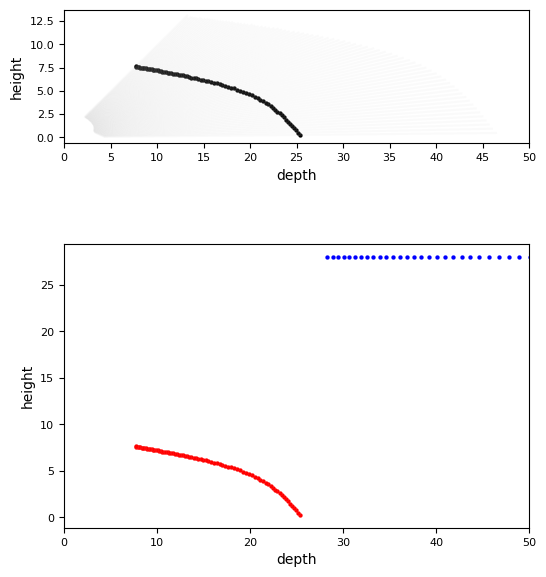

In [25]:
prior_data = pd.read_csv("prior_data_journal.csv")

fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# plt.axes().set_aspect('equal')
df_uniform = prior_and_inference(beam_height, 1, 0)
df_variance = prior_and_inference(beam_height, 0, 1)

for row in prior_data.values: # if plot_results is a DataFrame
    x1 = row[3] 
    y1 = row[5] 
    x2 = row[4]
    y2 = row[6]
    axes[0].plot([x1,x2],[y1,y2], color = 'lightgrey', alpha=0.1) # plot one line for every row in the DataFrame.
sns.scatterplot(ax=axes[0], data=prior_data, x="Depth", y="Height", s=markersize, linewidth=0.03, color = 'black', zorder = 1)
plt.xlim(xmin=0)

# axes[0].set_title("s = 0")
axes[0].set_xlabel("depth")
axes[0].set_ylabel("height")
axes[0].set_xticks(range(0, 55, 5))
axes[0].set_aspect('equal')

sns.scatterplot(ax=axes[1], data=df_uniform, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0.03, color = 'red')
sns.scatterplot(ax=axes[1], data=df_uniform, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[1].set_xlim([0, 50])
axes[1].set_xlabel("depth")
axes[1].set_ylabel("height")
axes[1].set_aspect('equal')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("../output/figures/prior_and_inference_journal.svg")

Now consider a beam viewed from the side

/Users/ckemp/miniconda3/envs/py310/lib/python3.11/site-packages/numpy/ma/core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


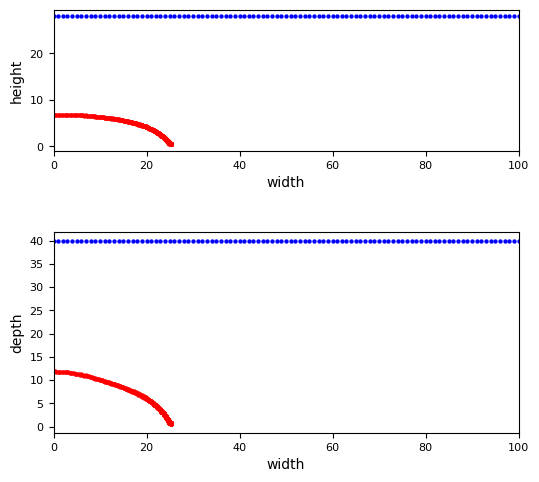

In [26]:
# row-wise prior over the distances in distance_prior
row_sums = weight_prior.sum(axis=1)
prior = weight_prior / row_sums[:, np.newaxis]

dmin, dmax = (0,1500)                       # offsets
horiz_offsets = np.arange(dmin,dmax, 0.2)
horiz_offsets = np.arange(dmin,dmax, 1)
s = 40                                     # separation between observer and beam

side_df = pd.DataFrame(horiz_offsets, columns=['horiz_offset'])
side_df['height'] = beam_height
side_df['depth']  = s
side_df['distance'] = np.sqrt(side_df['horiz_offset']**2 + side_df['height']**2 + side_df['depth']**2)
side_df['angle'] = np.arctan(side_df['height']/side_df['distance'])
side_df['alpha'] = np.arctan(side_df['horiz_offset']/side_df['depth']) # angle in horizontal plane relative to direction of gaze

# find indices of the closest angles in the original data to the offset points on sideways beam
angle_indices = [np.argmin(abs(df['Angle']-side_df['angle'][i])) for i in range(len(side_df['angle']))]
side_df['distance_inferred'] = posterior_mean(side_df['distance'], distance_prior_masked[angle_indices,:], prior[angle_indices,:], 0, 0)
side_df['distance_inferred_constnoise'] = posterior_mean(side_df['distance'], distance_prior_masked[angle_indices,:], prior[angle_indices,:], 0, 1)
side_df['distance_inferred_ddnoise'] = posterior_mean(side_df['distance'], distance_prior_masked[angle_indices,:], prior[angle_indices,:], 1, 1)

side_df['height_inferred'] = side_df['distance_inferred'] * np.sin(side_df['angle'])
side_df['dist_hplane_inferred'] = side_df['distance_inferred'] * np.cos(side_df['angle'])
side_df['depth_inferred'] = side_df['dist_hplane_inferred'] * np.cos(side_df['alpha'])
side_df['horiz_offset_inferred'] = side_df['dist_hplane_inferred'] * np.sin(side_df['alpha'])

side_df['height_inferred_constnoise'] = side_df['distance_inferred_constnoise'] * np.sin(side_df['angle'])
side_df['dist_hplane_inferred_constnoise'] = side_df['distance_inferred_constnoise'] * np.cos(side_df['angle'])
side_df['depth_inferred_constnoise'] = side_df['dist_hplane_inferred_constnoise'] * np.cos(side_df['alpha'])
side_df['horiz_offset_inferred_constnoise'] = side_df['dist_hplane_inferred_constnoise'] * np.sin(side_df['alpha'])

side_df['height_inferred_ddnoise'] = side_df['distance_inferred_ddnoise'] * np.sin(side_df['angle'])
side_df['dist_hplane_inferred_ddnoise'] = side_df['distance_inferred_ddnoise'] * np.cos(side_df['angle'])
side_df['depth_inferred_ddnoise'] = side_df['dist_hplane_inferred_ddnoise'] * np.cos(side_df['alpha'])
side_df['horiz_offset_inferred_ddnoise'] = side_df['dist_hplane_inferred_ddnoise'] * np.sin(side_df['alpha'])


fig, axes = plt.subplots(2, 1, figsize=(6, 6))

sns.scatterplot(ax=axes[0], data=side_df, x="horiz_offset", y="height", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[0], data=side_df, x="horiz_offset_inferred", y="height_inferred", color = 'red', s=markersize, linewidth=0)
axes[0].set_xlabel("width")
axes[0].set_ylabel("height")
axes[0].set_xlim([0, 100])
axes[0].set_aspect('equal')


sns.scatterplot(ax=axes[1], data=side_df, x="horiz_offset", y="depth", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[1], data=side_df, x="horiz_offset_inferred", y="depth_inferred", color = 'red', s=markersize, linewidth=0)
axes[1].set_xlabel("width")
axes[1].set_ylabel("depth")
axes[1].set_xlim([0, 100])
axes[1].set_aspect('equal') 
plt.show()

Assemble panels for Figure 2 in the paper

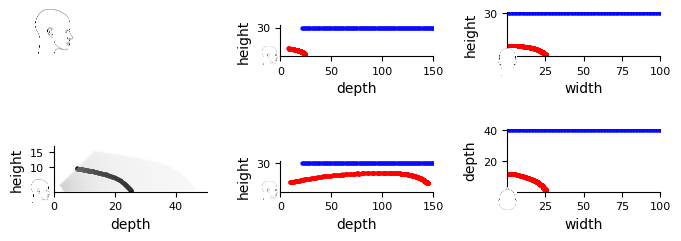

In [27]:
# Make combination plot

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)
plt.rcParams['axes.labelsize'] = 10

fig, axes = plt.subplots(2, 3, figsize=(7, 5))

# dimensions of side view of head
side_width = 6.11
side_height = 7.53
back_width = 6
back_height = 45.49/5
top_width = 6
top_height = 37/5

axes[0,0].set_xlim([0,50])
axes[0,0].set_aspect('equal')
axes[0,0].axis('off')
img_side = plt.imread("figure_pieces/head_side.png") # read your image file
axes[0,0].imshow(img_side, extent=[-side_width, side_width, -side_height, side_height], clip_on = False, zorder= 100) # add the image to the axes

for row in prior_data.values: # if plot_results is a DataFrame
    x1 = row[3] 
    y1 = row[5] 
    x2 = row[4]
    y2 = row[6]
    axes[1,0].plot([x1,x2],[y1,y2], color = 'lightgrey', alpha=0.1) # plot one line for every row in the DataFrame.
sns.scatterplot(ax=axes[1,0], data=prior_data, x="Depth", y="Height", s=markersize, linewidth=0, color = 'black')
axes[1,0].set_xlim([0,50])
axes[1,0].set_ylim([0,15])
axes[1,0].set_xlabel("depth")
axes[1,0].set_ylabel("height")
axes[1,0].set_aspect('equal')
axes[1,0].spines[['right', 'top']].set_visible(False)
axes[1,0].set_yticks([8,13])
axes[1,0].set_yticklabels(['10','15'])
axes[1,0].imshow(img_side, extent=[-1.2*side_width, -0.2*side_width, -0.5*side_height, 0.5*side_height], clip_on = False, zorder=100) # add the image to the axes


sns.scatterplot(ax=axes[0,1], data=df_uniform_dense, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0, color = 'red')
sns.scatterplot(ax=axes[0,1], data=df_uniform_dense, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[0,1].set_xlim([0, 150])
axes[0,1].set_ylim([0,30])
axes[0,1].set_xlabel("depth")
axes[0,1].set_ylabel("height")
axes[0,1].set_aspect('equal')
axes[0,1].spines[['right', 'top']].set_visible(False)
axes[0,1].set_yticks([28])
axes[0,1].set_yticklabels(['30'])
headmult = 0.25
axes[0,1].imshow(img_side, extent=[-headmult*12*side_width, -headmult*2*side_width, -headmult*5*side_height, headmult*5*side_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[1,1], data=df_constnoise_dense, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0, color = 'red')
sns.scatterplot(ax=axes[1,1], data=df_constnoise_dense, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[1,1].set_xlim([0, 150])
axes[1,1].set_ylim([0,30])
axes[1,1].set_xlabel("depth")
axes[1,1].set_ylabel("height")
axes[1,1].set_aspect('equal')
axes[1,1].set_yticks([28])
axes[1,1].set_yticklabels(['30'])
axes[1,1].spines[['right', 'top']].set_visible(False)
axes[1,1].imshow(img_side, extent=[-headmult*12*side_width, -headmult*2*side_width, -headmult*5*side_height, headmult*5*side_height], clip_on = False, zorder=100) # add the image to the axes

img_back = plt.imread("figure_pieces/head_back.png") # read image file
sns.scatterplot(ax=axes[0,2], data=side_df, x="horiz_offset", y="height", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[0,2], data=side_df, x="horiz_offset_inferred", y="height_inferred", color = 'red', s=markersize, linewidth=0)
axes[0,2].set_xlabel("width")
axes[0,2].set_ylabel("height")
axes[0,2].set_xlim([0, 100])
axes[0,2].set_yticks([28])
axes[0,2].set_yticklabels(['30'])
axes[0,2].set_ylim([0,29])
axes[0,2].set_aspect('equal')
axes[0,2].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[0,2].imshow(img_back, extent=[-headmult*5*back_width, headmult*5*back_width, -headmult*7*back_height, headmult*3*back_height], clip_on = False, zorder=100) # add the image to the axes


img_top = plt.imread("figure_pieces/head_top.png") # read image file
sns.scatterplot(ax=axes[1,2], data=side_df, x="horiz_offset", y="depth", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[1,2], data=side_df, x="horiz_offset_inferred", y="depth_inferred", color = 'red', s=markersize, linewidth=0)
axes[1,2].set_xlabel("width")
axes[1,2].set_ylabel("depth")
axes[1,2].set_xlim([0, 100])
axes[1,2].set_yticks([20,40])
axes[1,2].set_ylim([0,41])
axes[1,2].set_aspect('equal') 
axes[1,2].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[1,2].imshow(img_top, extent=[-headmult*5*top_width, headmult*5*top_width, -headmult*8*top_height, headmult*2*top_height], clip_on = False, zorder=100) # add the image to the axes


axes[0,0].set_anchor('SW')
axes[1,0].set_anchor('SW')
axes[0,1].set_anchor('SW')
axes[1,1].set_anchor('SW')
axes[0,2].set_anchor('SW')
axes[1,2].set_anchor('SW')

plt.subplots_adjust(wspace=1, hspace=-0.5)
#plt.gcf().set_size_inches(7, 5)
plt.tight_layout()
plt.savefig("../output/figures/journal_bentbeam.svg", dpi = 2000)
plt.show()

Now make results for alternative likelihood functions  (Figure S1)

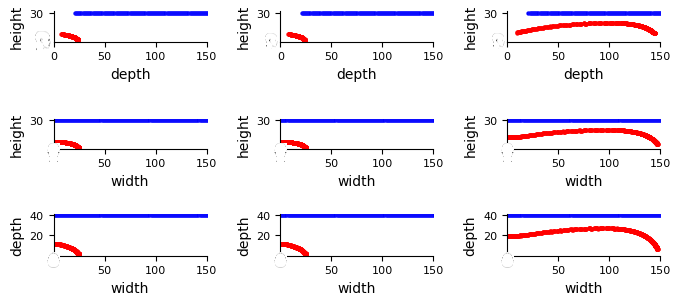

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(7, 5))

sns.scatterplot(ax=axes[0,0], data=df_uniform_dense, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0, color = 'red')
sns.scatterplot(ax=axes[0,0], data=df_uniform_dense, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[0,0].set_xlim([0, 150])
axes[0,0].set_ylim([0,30])
axes[0,0].set_xlabel("depth")
axes[0,0].set_ylabel("height")
axes[0,0].set_aspect('equal')
axes[0,0].spines[['right', 'top']].set_visible(False)
axes[0,0].set_yticks([28])
axes[0,0].set_yticklabels(['30'])
headmult = 0.25
axes[0,0].imshow(img_side, extent=[-headmult*12*side_width, -headmult*2*side_width, -headmult*5*side_height, headmult*5*side_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[1,0], data=side_df, x="horiz_offset", y="height", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[1,0], data=side_df, x="horiz_offset_inferred", y="height_inferred", color = 'red', s=markersize, linewidth=0)
axes[1,0].set_xlabel("width")
axes[1,0].set_ylabel("height")
axes[1,0].set_xlim([0, 150])
axes[1,0].set_yticks([28])
axes[1,0].set_yticklabels(['30'])
axes[1,0].set_xticks([0, 50, 100, 150])
axes[1,0].set_xticklabels(['', '50', '100', '150'])
axes[1,0].set_ylim([0,29])
axes[1,0].set_aspect('equal')
axes[1,0].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[1,0].imshow(img_back, extent=[-headmult*5*back_width, headmult*5*back_width, -headmult*7*back_height, headmult*3*back_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[2,0], data=side_df, x="horiz_offset", y="depth", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[2,0], data=side_df, x="horiz_offset_inferred", y="depth_inferred", color = 'red', s=markersize, linewidth=0)
axes[2,0].set_xlabel("width")
axes[2,0].set_ylabel("depth")
axes[2,0].set_xlim([0, 150])
axes[2,0].set_yticks([20,40])
axes[2,0].set_ylim([0,41])
axes[2,0].set_aspect('equal') 
axes[2,0].spines[['right', 'top']].set_visible(False)
axes[2,0].set_xticks([0, 50, 100, 150])
axes[2,0].set_xticklabels(['', '50', '100', '150'])
headmult = 0.2
axes[2,0].imshow(img_top, extent=[-headmult*5*top_width, headmult*5*top_width, -headmult*8*top_height, headmult*2*top_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[0,1], data=df_ddnoise_dense, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0, color = 'red')
sns.scatterplot(ax=axes[0,1], data=df_ddnoise_dense, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[0,1].set_xlim([0, 150])
axes[0,1].set_ylim([0,30])
axes[0,1].set_xlabel("depth")
axes[0,1].set_ylabel("height")
axes[0,1].set_aspect('equal')
axes[0,1].set_yticks([28])
axes[0,1].set_yticklabels(['30'])
axes[0,1].spines[['right', 'top']].set_visible(False)
axes[0,1].imshow(img_side, extent=[-headmult*12*side_width, -headmult*2*side_width, -headmult*5*side_height, headmult*5*side_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[1,1], data=side_df, x="horiz_offset", y="height", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[1,1], data=side_df, x="horiz_offset_inferred_ddnoise", y="height_inferred_ddnoise", color = 'red', s=markersize, linewidth=0)
axes[1,1].set_xlabel("width")
axes[1,1].set_ylabel("height")
axes[1,1].set_xlim([0, 150])
axes[1,1].set_yticks([28])
axes[1,1].set_yticklabels(['30'])
axes[1,1].set_xticks([0, 50, 100, 150])
axes[1,1].set_xticklabels(['', '50', '100', '150'])
axes[1,1].set_ylim([0,29])
axes[1,1].set_aspect('equal')
axes[1,1].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[1,1].imshow(img_back, extent=[-headmult*5*back_width, headmult*5*back_width, -headmult*7*back_height, headmult*3*back_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[2,1], data=side_df, x="horiz_offset", y="depth", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[2,1], data=side_df, x="horiz_offset_inferred_ddnoise", y="depth_inferred_ddnoise", color = 'red', s=markersize, linewidth=0)
axes[2,1].set_xlabel("width")
axes[2,1].set_ylabel("depth")
axes[2,1].set_xlim([0, 150])
axes[2,1].set_yticks([20,40])
axes[2,1].set_ylim([0,41])
axes[2,1].set_xticks([0, 50, 100, 150])
axes[2,1].set_xticklabels(['', '50', '100', '150'])
axes[2,1].set_aspect('equal') 
axes[2,1].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[2,1].imshow(img_top, extent=[-headmult*5*top_width, headmult*5*top_width, -headmult*8*top_height, headmult*2*top_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[0,2], data=df_constnoise_dense, x="depth_inferred", y="height_inferred", s = markersize, linewidth=0, color = 'red')
sns.scatterplot(ax=axes[0,2], data=df_constnoise_dense, x="depth_true", y="height_true", s = markersize, linewidth=0.03, color = 'blue') # true beam in red
axes[0,2].set_xlim([0, 150])
axes[0,2].set_ylim([0,30])
axes[0,2].set_xlabel("depth")
axes[0,2].set_ylabel("height")
axes[0,2].set_aspect('equal')
axes[0,2].set_yticks([28])
axes[0,2].set_yticklabels(['30'])
axes[0,2].spines[['right', 'top']].set_visible(False)
axes[0,2].imshow(img_side, extent=[-headmult*12*side_width, -headmult*2*side_width, -headmult*5*side_height, headmult*5*side_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[1,2], data=side_df, x="horiz_offset", y="height", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[1,2], data=side_df, x="horiz_offset_inferred_constnoise", y="height_inferred_constnoise", color = 'red', s=markersize, linewidth=0)
axes[1,2].set_xlabel("width")
axes[1,2].set_ylabel("height")
axes[1,2].set_xlim([0, 150])
axes[1,2].set_yticks([28])
axes[1,2].set_yticklabels(['30'])
axes[1,2].set_ylim([0,29])
axes[1,2].set_xticks([0, 50, 100, 150])
axes[1,2].set_xticklabels(['', '50', '100', '150'])
axes[1,2].set_aspect('equal')
axes[1,2].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[1,2].imshow(img_back, extent=[-headmult*5*back_width, headmult*5*back_width, -headmult*7*back_height, headmult*3*back_height], clip_on = False, zorder=100) # add the image to the axes

sns.scatterplot(ax=axes[2,2], data=side_df, x="horiz_offset", y="depth", color = 'blue', s=markersize, linewidth=0.03)
sns.scatterplot(ax=axes[2,2], data=side_df, x="horiz_offset_inferred_constnoise", y="depth_inferred_constnoise", color = 'red', s=markersize, linewidth=0)
axes[2,2].set_xlabel("width")
axes[2,2].set_ylabel("depth")
axes[2,2].set_xlim([0, 150])
axes[2,2].set_yticks([20,40])
axes[2,2].set_ylim([0,41])
axes[2,2].set_xticks([0, 50, 100, 150])
axes[2,2].set_xticklabels(['', '50', '100', '150'])
axes[2,2].set_aspect('equal') 
axes[2,2].spines[['right', 'top']].set_visible(False)
headmult = 0.2
axes[2,2].imshow(img_top, extent=[-headmult*5*top_width, headmult*5*top_width, -headmult*8*top_height, headmult*2*top_height], clip_on = False, zorder=100) # add the image to the axes

axes[0,0].set_anchor('SW')
axes[1,0].set_anchor('SW')
axes[2,0].set_anchor('SW')
axes[0,1].set_anchor('SW')
axes[1,1].set_anchor('SW')
axes[2,1].set_anchor('SW')
axes[0,2].set_anchor('SW')
axes[1,2].set_anchor('SW')
axes[2,2].set_anchor('SW')

plt.subplots_adjust(wspace=1, hspace=-0.5)
#plt.gcf().set_size_inches(7, 5)
plt.tight_layout()
plt.savefig("../output/figures/journal_alternativelikelihoods.svg", dpi = 2000)
plt.show()

### Phantom Lighthouse Illusion

Now consider two snapshots of the beam at 0 and $2 \theta$ degrees with respect to the axis of the observer. Assume that the lighthouse makes a full rotation every 40 seconds. Assume that the observer is $s$ metres in front of the lighthouse with her back to the lighthouse ($s$ for separation). 

Consider a point on the beam that has a horizontal distance of $t$ metres with respect to the observer when the beam runs directly over her head (so the point has depth of $s+t$ with respect to the lighthouse). After the beam rotates through an angle of $2\theta$, the horizontal distance between observer and the point is $w$. Some trigonometry shows that
$$ w = \sqrt{t^2 + 4 (s+t)^2 \sin^2 \theta - 4t(s+t)\sin(90-\theta)\cos(90-\theta)} $$

In [29]:
#### 
full_rotation_time = 40
time_per_degree = full_rotation_time / 360
theta = np.deg2rad(0.01) # half of the rotation angle

def prior_frame(s, origdf):
    df = origdf.copy(deep=True)
    # depths for rotated points are in rotated coordinates (corresponding x coordinate is zero)
    df['depth_true_rotated'] = np.sqrt(df['depth_true']**2 + 
                                            4*(s + df['depth_true'])**2*np.sin(theta)**2 -
                                            4*df['depth_true']*(s + df['depth_true'])*np.sin(theta)*np.cos(np.pi/4 - theta))
    df['distance_true_rotated'] = np.sqrt(df['depth_true_rotated']**2 + df['height_true']**2)
    df['angle_rotated'] = np.arctan(df['height_true']/df['depth_true_rotated'])

    # find indices of the closest angles in the original data to the rotated angles
    #angle_indices = [np.argmin(abs(df['angle']-df['angle_rotated'][i])) for i in range(len(df['angle_rotated']))]
    angle_indices = [np.argmin(abs(angles-df['angle_rotated'][i])) for i in range(len(df['angle_rotated']))]
    
    df['distance_inferred_rotated'] = posterior_mean(df['distance_true_rotated'], distance_prior_masked[angle_indices,:], prior[angle_indices,:],  dd_scaling, likelihood_multiplier)
    df['height_inferred_rotated'] = df['distance_inferred_rotated'] * np.sin(df['angle_rotated'])
    df['depth_inferred_rotated'] = df['distance_inferred_rotated'] * np.cos(df['angle_rotated'])

    # alpha is angle between matching points on the beam and the observer
    df['alphas'] = np.arccos( (df['depth_true']**2 + df['depth_true_rotated']**2 
                                    - 4*(s + df['depth_true'])**2 * np.sin(theta)**2) / (2*df['depth_true']*df['depth_true_rotated']) )

    # compute inferred distance travelled between points on a beam at -2*theta and corresponding points on the 2*theta beam  
    # this approach is useful because corresponding points are inferred to have the same height and the same depth --
    # so the resulting velocity estimate captures only circular motion
    df['travelled_inferred'] = np.sqrt(2*df['depth_inferred_rotated']**2 *(1-np.cos(2*df['alphas'])))
    df['velocity_inferred'] = df['travelled_inferred']/(time_per_degree*2*np.rad2deg(theta))
    return df


Inferences when s = 66:
    depth_inferred  velocity_inferred
0        25.403872           5.776798
1        25.168826           5.855214
2        24.943118           5.933442
3        24.720668           6.010175
4        24.507037           6.086869
..             ...                ...
73        8.207170           5.748597
74        8.067425           5.728902
75        7.925844           5.706620
76        7.764194           5.668365
77        7.764194           5.748028

[78 rows x 2 columns]
Inferences when s = 67:
    depth_inferred  velocity_inferred
0        25.403872           5.778814
1        25.168826           5.859210
2        24.943118           5.939383
3        24.720668           6.018027
4        24.507037           6.096602
..             ...                ...
73        8.207170           5.808091
74        8.067425           5.788569
75        7.925844           5.766425
76        7.764194           5.728135
77        7.764194           5.809005

[78 rows x 2 col

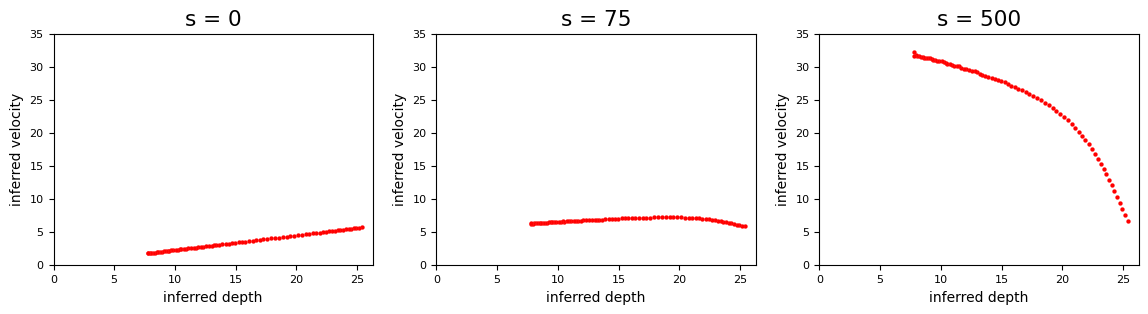

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

s0 = prior_frame(0, df_uniform)
sns.scatterplot(ax=axes[0], data=s0, x="depth_inferred", y="velocity_inferred", s=markersize, linewidth=0.03, color = 'red')
axes[0].set_title("s = 0")
axes[0].set_xlabel("inferred depth")
axes[0].set_ylabel("inferred velocity")

s75 = prior_frame(75, df_uniform)
sns.scatterplot(ax=axes[1], data=s75, x="depth_inferred", y="velocity_inferred", s=markersize, linewidth=0.03, color = 'red')
axes[1].set_title("s = 75")
axes[1].set_xlabel("inferred depth")
axes[1].set_ylabel("inferred velocity")

s500 = prior_frame(500, df_uniform)
sns.scatterplot(ax=axes[2], data=s500, x="depth_inferred", y="velocity_inferred", s=markersize, linewidth=0.03, color = 'red')
axes[2].set_title("s = 500")
axes[2].set_xlabel("inferred depth")
axes[2].set_ylabel("inferred velocity")
plt.setp(axes, xlim=0, ylim= (0, 35))

s67 = prior_frame(67, df_uniform)
preds_67 = s67[['depth_inferred', 'velocity_inferred']]
s66 = prior_frame(66, df_uniform)
preds_66 = s66[['depth_inferred', 'velocity_inferred']]

plt.savefig("../output/figures/Velocity.svg", dpi = 2000)

print("Inferences when s = 66:")
print(preds_66)
print("Inferences when s = 67:")
print(preds_67)

The two dataframes printed above suggest that the critical point occurs at around s = 67. When s = 66, the inferred velocity of the most distant point exceeds the inferred velocity of the closest point, but the opposite holds for s = 67.  We've picked 75 as a round number (halfway between 50 and 100) because the prior used in these analyses is only an approximation to a prior based on environmental statistics.